In [10]:
import torch 
import torchvision

import matplotlib.pyplot as plt 
from torchvision import transforms

import os 
import zipfile
from pathlib import Path
import requests

# import the going modular library 
from going_modular import data_setup,engine

In [2]:
print(torch.__version__)
print(torchvision.__version__)


2.0.1+cu117
0.15.2+cu117


In [3]:
# try torch info, install if it doesn't work 
try:
    from torchinfo import summary
except:
    print("Couldn't find torch info ... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary 

In [6]:
# setup device agnostic code 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
# download data 
data_path = Path('data/')
image_path = data_path/'pizza_steak_sushi'

if image_path.is_dir():
    print(f'{image_path} diectory exists.')
else:
    print(f"Didn't find {image_path} directory, creating one..")
    image_path.mkdir(parents=True,exist_ok=True)
    
    with open(data_path/'pizza_steak_sushi.zip','wb') as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("downloading pizza, steak and sushi data...")
        f.write(request.content)
        
    with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip', 'r') as zip_ref:
        print("Unzipping pizza steak and sushi data")
        zip_ref.extractall(image_path)
    os.remove(data_path/"pizza_steak_sushi.zip")

data/pizza_steak_sushi diectory exists.


In [11]:
# setup the train and test dirs 
train_dir = image_path / "train"
test_dir = image_path / "test"

In [9]:
# create a manul transformer pipeline (we need to makesure that our custom data going to model is prepared in the same way 
# as the original datathat went into the model)
manual_transform = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(), 
                                       transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])


In [12]:
# creating training and testing data loaders 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,test_dir=test_dir,
                                                                               transform=manual_transform,batch_size=32)

In [14]:
# there is another(easy) way of creating transforms for torchvision.models

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # get the pre-trained model weights 
auto_transforms = weights.transforms() # get the transforms used to create pre-trained weights 

print(weights, auto_transforms)

EfficientNet_B0_Weights.IMAGENET1K_V1 ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [15]:
# creating training and testing data loaders with new transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,test_dir=test_dir,
                                                                               transform=auto_transforms,batch_size=32)

In [ ]:
# get the model and initialize with pre-trained weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [18]:
from torchinfo import summary
summary(model=model,input_size=(32,3,224,224), col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [19]:
# freeze all the base layers in the feature section of the model 
for param in model.features.parameters():
    param.requires_grad = False

In [21]:
# get the output shape, since we have 3 things (pizza, steak, sushi) it is 3 now
output_shape = len(class_names)
print(output_shape)

# recreate the classifier layer and seed it into target device 
model.classifier = torch.nn.Sequential(torch.nn.Dropout(p=0.2,inplace=True),
                                       torch.nn.Linear(in_features=1280,out_features=output_shape,bias=True)).to(device)

3


In [22]:
# print summery of the modified model 
summary(model=model,input_size=(32,3,224,224), col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [23]:
# define the loss function and optimizer 
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [25]:
# train the model 
results = engine.train(model=model,train_dataloader=train_dataloader,test_dataloader=test_dataloader,
                       optimizer=optimizer,loss_fn=loss_fn,epochs=5,device=device)

Epoch: 1 | train_loss: 1.0344 | train_acc: 0.4609 | test_loss: 0.8978 | test_acc: 0.6525
Epoch: 2 | train_loss: 0.8416 | train_acc: 0.7344 | test_loss: 0.7951 | test_acc: 0.6818
Epoch: 3 | train_loss: 0.7366 | train_acc: 0.7500 | test_loss: 0.7541 | test_acc: 0.7330
Epoch: 4 | train_loss: 0.7040 | train_acc: 0.7031 | test_loss: 0.6814 | test_acc: 0.7841
Epoch: 5 | train_loss: 0.6417 | train_acc: 0.7812 | test_loss: 0.5724 | test_acc: 0.8655


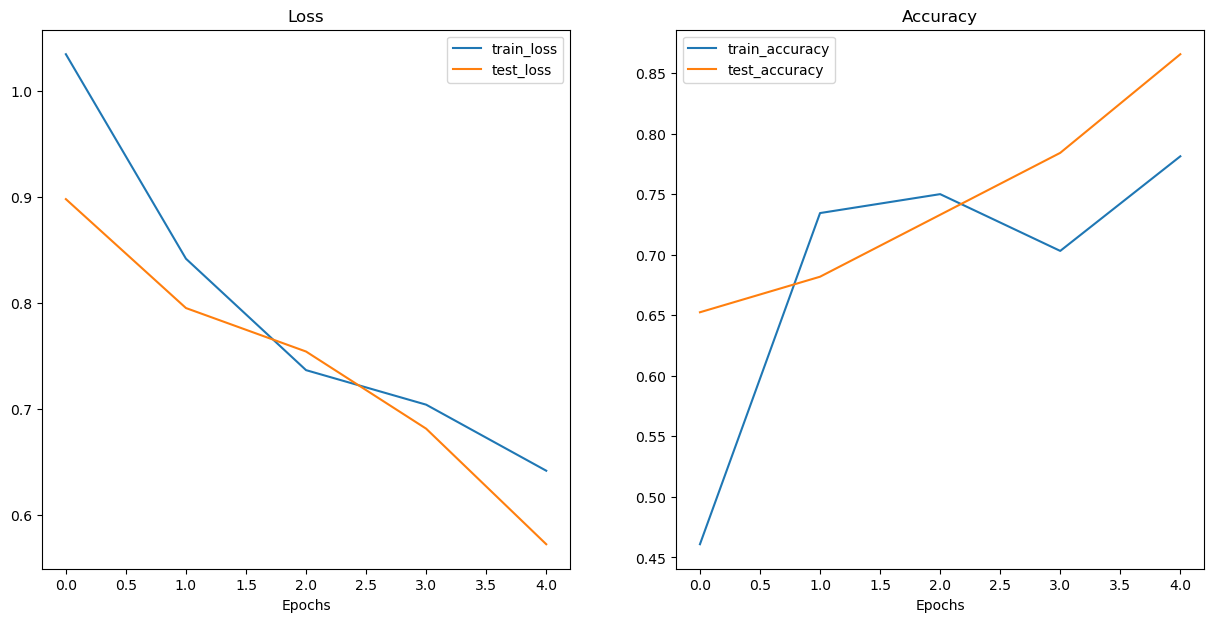

In [35]:
# plot train/test losses
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [36]:
# function to plot image and give the predictions (label and probability)

from PIL import Image 
from typing import List, Tuple

def pred_and_plot_image(model:torch.nn.Module, image_path:str, class_names: List[str],image_size: Tuple[int,int]=(224,224),
                        transforms:torchvision.transforms=None,device:torch.device = device):
    img = Image.open(image_path)
    
    if transforms is not None:
        image_transform  = transforms
    else:
        image_transform = transforms.Compose([transforms.Resize(image_size)], transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]))
        
    model.to(device)
    
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))
        
    target_image_pred_probs = torch.softmax(target_image_pred,dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs,dim=1)
    
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred:{class_names[target_image_pred_label]} | Prob : {target_image_pred_probs.max():.3f}")
    plt.axis(False)
        

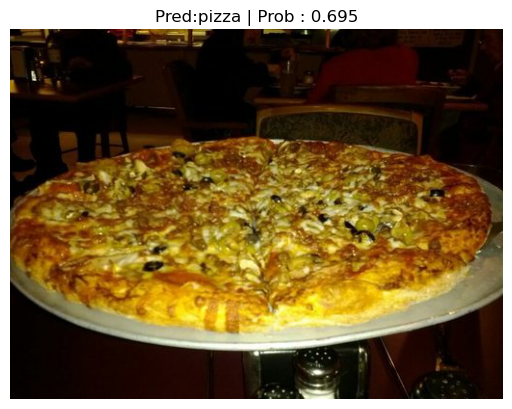

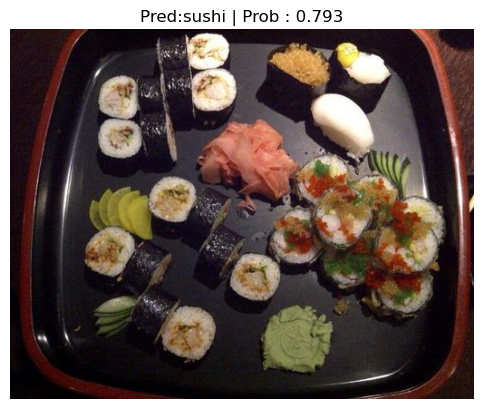

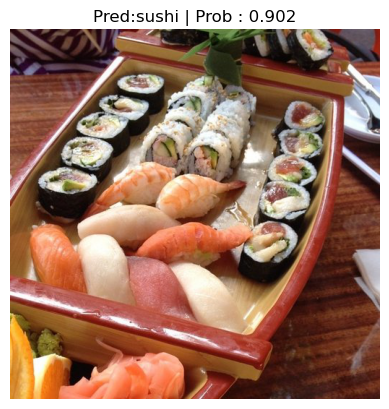

In [39]:
# get a random list of image paths from test set 

import random 
num_images_to_plot = 3 
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, k=num_images_to_plot)

# make predictions on the selected images 
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,image_path=image_path,class_names=class_names,transforms=weights.transforms())

data/04-pizza-dad.jpeg already exists, skipping download.


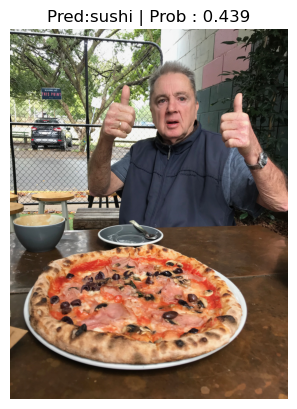

In [41]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,image_path=custom_image_path,
                    class_names=class_names,transforms=weights.transforms())